## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Load Data

In [ ]:
data=pd.read_excel("m08_bonus.xlsx")
data

,Longitude,Latitude,Altitude
0,-79.971666,40.473853,237
1,-79.971816,40.473682,237
2,-79.972547,40.472036,237
3,-79.973845,40.471470,237
4,-79.974435,40.470674,237
...,...,...,...
1249,-79.957314,40.454789,363
1250,-79.957522,40.455206,363
1251,-79.958293,40.456033,363
1252,-79.959477,40.455430,363


In [ ]:
X=torch.tensor(data[['Longitude','Latitude']].to_numpy()).float()
Y=torch.tensor(data['Altitude'].to_numpy()).float().unsqueeze(1)

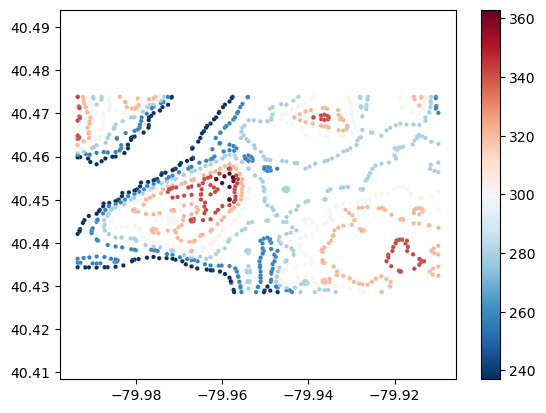

In [ ]:
lims = dict(cmap='RdBu_r', vmin=Y.min(), vmax=Y.max())
# plt.figure(figsize=(7,6))
plt.scatter(X[:, 0], X[:, 1], 10, Y, edgecolor='w', lw=0.1, **lims)
plt.axis('equal')
plt.colorbar(cmap='RdBu_r')
plt.show()

Split the dataset into trainig and validation sets

In [ ]:
x_train,x_val,y_train,y_val=train_test_split(X,Y,test_size=0.2,random_state=42)

We want to scale the input and output first, as the range is much larger than the variation amonount of longitude/latitude

In [ ]:
scalerx = StandardScaler()
x_train = scalerx.fit_transform(x_train)
x_val = scalerx.transform(x_val)
scalery = StandardScaler()
y_train = scalery.fit_transform(y_train)
y_val = scalery.transform(y_val)

x_train = torch.tensor(x_train).float()
x_val = torch.tensor(x_val).float()
y_train = torch.tensor(y_train).float()
y_val = torch.tensor(y_val).float()

## Define model

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.act = torch.relu
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x

## Train the model

In [ ]:
model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 5000
train_hist = []
val_hist = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    train_hist.append(loss.item())

    model.eval()
    outputs = model(x_val)
    loss_val = criterion(outputs, y_val)
    val_hist.append(loss_val.item())

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Val Loss: {loss_val.item():.4f}')

Epoch [100/5000], Training Loss: 0.7284, Val Loss: 0.7633
Epoch [200/5000], Training Loss: 0.4797, Val Loss: 0.4860
Epoch [300/5000], Training Loss: 0.3203, Val Loss: 0.3282
Epoch [400/5000], Training Loss: 0.2393, Val Loss: 0.2498
Epoch [500/5000], Training Loss: 0.1985, Val Loss: 0.2154
Epoch [600/5000], Training Loss: 0.1744, Val Loss: 0.1897
Epoch [700/5000], Training Loss: 0.1594, Val Loss: 0.1790
Epoch [800/5000], Training Loss: 0.1488, Val Loss: 0.1705
Epoch [900/5000], Training Loss: 0.1413, Val Loss: 0.1633
Epoch [1000/5000], Training Loss: 0.1341, Val Loss: 0.1560
Epoch [1100/5000], Training Loss: 0.1273, Val Loss: 0.1482
Epoch [1200/5000], Training Loss: 0.1202, Val Loss: 0.1401
Epoch [1300/5000], Training Loss: 0.1136, Val Loss: 0.1339
Epoch [1400/5000], Training Loss: 0.1094, Val Loss: 0.1293
Epoch [1500/5000], Training Loss: 0.1066, Val Loss: 0.1259
Epoch [1600/5000], Training Loss: 0.1036, Val Loss: 0.1231
Epoch [1700/5000], Training Loss: 0.1006, Val Loss: 0.1199
Epoch 

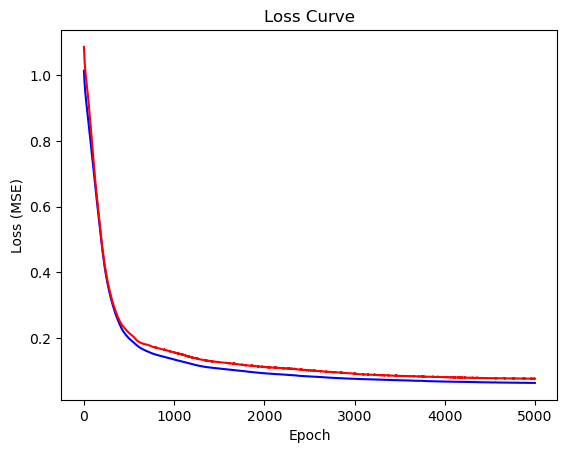

In [ ]:
plt.plot(train_hist, color='blue')
plt.plot(val_hist, color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Loss Curve')
plt.show()

## Visualize the fitted contour map

We define a grid of locations as sampling points, predict their altitudes using the trained model, then draw the contour map.

In [ ]:
# Define the range of the grid
x1_min, x1_max = min(X[:,0]), max(X[:,0])
x2_min, x2_max = min(X[:,1]), max(X[:,1])
num_grid = 100  # step size

# Generate the grid
xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, num_grid), np.linspace(x2_min, x2_max,num_grid))
grid = np.c_[xx.ravel(), yy.ravel()]


In [ ]:
model.eval()
with torch.no_grad():
    grid_tensor = torch.tensor(scalerx.transform(grid), dtype=torch.float32)
    predictions = model(grid_tensor)
predictions = predictions.numpy()

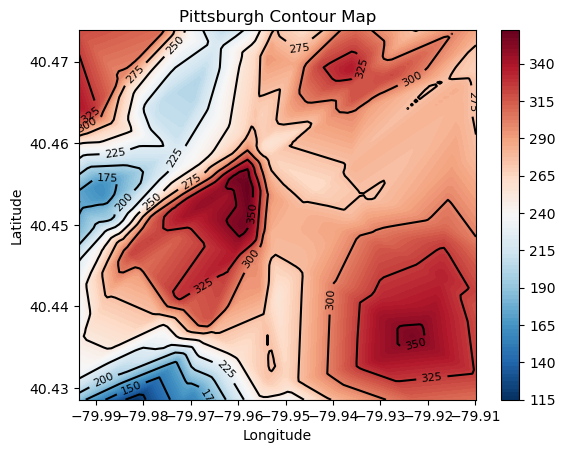

In [ ]:
predictions_origin=scalery.inverse_transform(predictions)
Z = predictions_origin.reshape(xx.shape)

# Plot the contour
plt.contourf(xx, yy, Z, levels=100, cmap='RdBu_r')
plt.colorbar()
# Add contour lines
contour_lines = plt.contour(xx, yy, Z, levels=10, colors='black')

# Add labels to contour lines
plt.clabel(contour_lines, inline=True, fontsize=8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Pittsburgh Contour Map')
plt.show()

## Use gradient ascent to find the peak

Define a location tensor as the optimization variable. We will use SGD as the optimizer

In [ ]:
location = torch.tensor([[0.0, 0.0]], dtype=torch.float32,requires_grad=True)
climber = optim.SGD([location], lr=0.001)

Iteratively optimize the locations to get to the local maximum.

In [ ]:
model.eval()

num_iterations = 1000
ascent_hist = []
for i in range(num_iterations):
    climber.zero_grad()
    altitude = model(location)
    al_loss = -altitude  # We want to maximize the altitude, so minimize the negative output
    ascent_hist.append(al_loss.item())
    al_loss.backward()
    climber.step()

    if i % 100 == 0:
        print(f"Iteration {i}:  Normalized Altitude: {-al_loss.item():.4f}")

# We want to map the scaled locations and altitude back to the orginal scale
peak_loc = scalerx.inverse_transform(location.detach().numpy())
peak_al = scalery.inverse_transform([[model(location).item()]])


Iteration 0:  Normalized Altitude: 0.8974
Iteration 100:  Normalized Altitude: 2.1919
Iteration 200:  Normalized Altitude: 2.2116
Iteration 300:  Normalized Altitude: 2.2313
Iteration 400:  Normalized Altitude: 2.2510
Iteration 500:  Normalized Altitude: 2.2707
Iteration 600:  Normalized Altitude: 2.2578
Iteration 700:  Normalized Altitude: 2.2663
Iteration 800:  Normalized Altitude: 2.2763
Iteration 900:  Normalized Altitude: 2.2847


We identify the location and altitude of the peak

In [ ]:
print(f"Peak location:  {peak_loc[:,1].item():.4f}N, {-peak_loc[:,0].item():.4f}W;  Peak altitude: {peak_al.item():.4f}m")


Peak location:  40.4548N, 79.9578W;  Peak altitude: 362.8438m


We can mark the found peak on the contour map

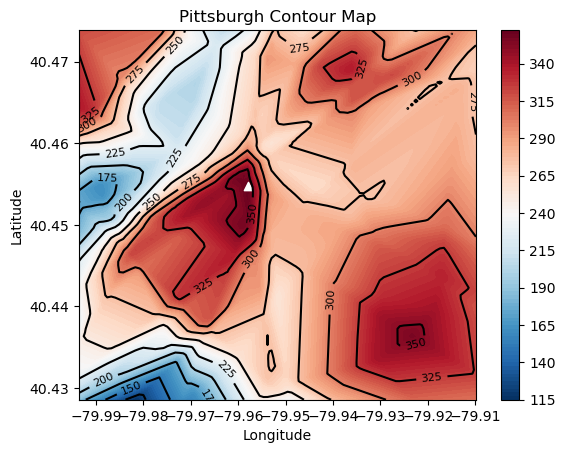

In [ ]:
Z = predictions_origin.reshape(xx.shape)

# Plot the contour
plt.contourf(xx, yy, Z, levels=100, cmap='RdBu_r')
plt.colorbar()
# Add contour lines
contour_lines = plt.contour(xx, yy, Z, levels=10, colors='black')

# Add labels to contour lines
plt.clabel(contour_lines, inline=True, fontsize=8)
plt.scatter(peak_loc[:,0], peak_loc[:,1], marker='^', color='white')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Pittsburgh Contour Map')
plt.show()

Search for the location with Google Map. The peak is Robert E. Williams Memorial Park based on the optimiztaion

![The peak location](./peak_location.jpg)